## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [3]:
import platform

if torch.cuda.is_available():
    print("The code will run on GPU.")
    device = torch.device('cuda')
elif platform.system() == 'Darwin':
    # For Mac, check for MPS (Apple Silicon GPU support)
    if torch.backends.mps.is_available():
        print("The code will run on Apple Silicon GPU (MPS).")
        device = torch.device('mps')
    else:
        print("The code will run on CPU. MPS not available.")
        device = torch.device('cpu')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
    device = torch.device('cpu')

The code will run on Apple Silicon GPU (MPS).


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [9]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Let's look at some images from our data 

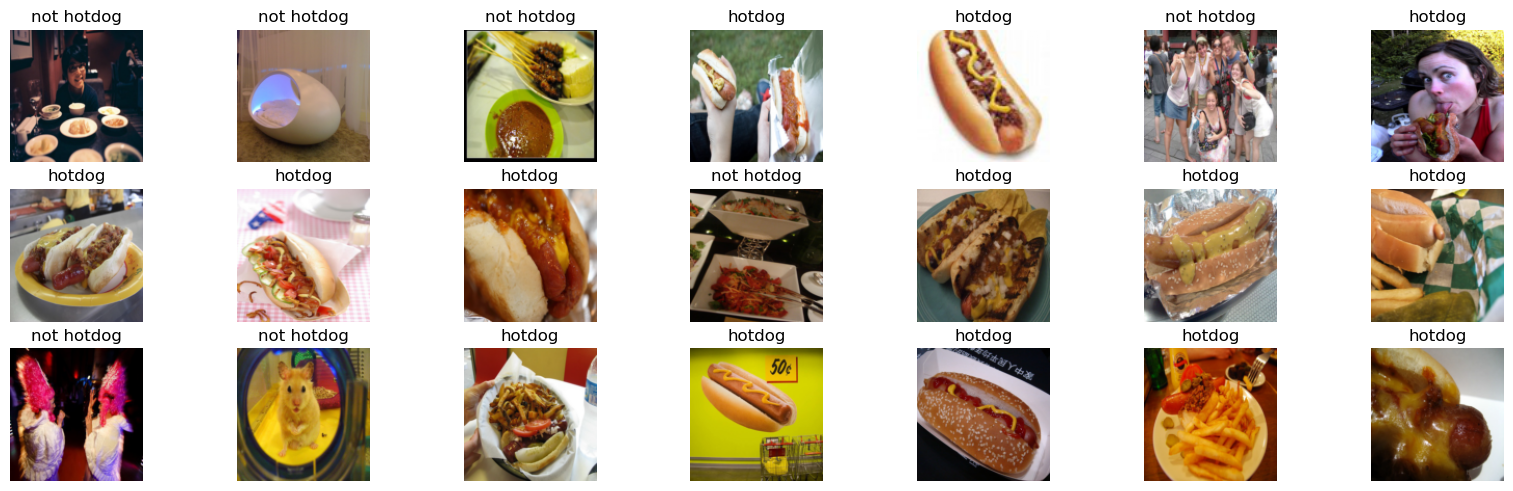

In [14]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


In [15]:
print(f"Training set size: {len(trainset)}")

Training set size: 2047


Now create a model and train it!
